# Introduction

The notebook examines the following:
* pyldpc for encoding and decoding of AWGN and Rayleigh-Jakes SOS channels
* Plotting BER vs SNR for uncoded and coded Rayleigh-Jakes channel
* Encoding and decoding in VAR case and potential integrations

Encoding -
- using a sparse parity-check matrix to place constraints on the parity bits
- uses a generator matrix to actually get the parity bits from the data bits

Decoding - for our channel, uses the sum-product message passing/belief propagation algorithm - need to understand in more detail

# pyldpc

Parameters:
- k = the number of bits to be transmitted originally before coding - this is the data we want to send per packet, so more packet size increases latency
- n = the number of bits to be transmitted after coding is done on k bits, so n-k parity bits is used
- H = parity check matrix
- G = generator matrix
- d_v = degree of the variable node - number of 1s per column in H
- d_c = degree of the check node - number of 1s per row in H

d_v and d_C along with n specify the structure of H and G. 

H has n columns and (n * d_v/d_c) = m rows. 

The rate of coding R = 1 - (m/n) = k/n

Closer R is to 1, more uncoded the data is, suitable for less noise or no noise. 

In [1]:
pip install pyldpc

Note: you may need to restart the kernel to use updated packages.


In [146]:
import numpy as np
from pyldpc import make_ldpc, encode, decode, get_message
from utils import *
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
import json
from statsmodels.tsa.ar_model import AutoReg
import numpy as np
from sympy import Matrix
import json
import argparse

In [57]:
#Demo with 11 bits (0 and 1) to be transmitted
#0 becomes 1 and 1 becomes -1 in symbol, coding is done before converting to a symbol, and decoding of the message occurs after converting the symbols to bits
n1 = 18
d_v1 = 3
d_c1 = 6
snr = 10
k = 11 #fixed if we fix the other 3 (not snr)

In [36]:
def transmit_data_awgn_real(data, snr_db):
    """
    Simulate data transmission over a wireless channel with noise.

    Args:
        data (np.ndarray): Input data to be transmitted.
        channel (complex or float): Channel gain.
        snr_db (float): Signal-to-noise ratio in decibels (dB). The formula to convert in linear scale is snr(dB) = 10log(snr(linear))

    Returns:
        np.ndarray: Noisy received signal.
    """
    # Apply channel gain to the transmitted data.
    signal = data
    # Calculate the signal power.
    signal_power = np.mean(np.abs(signal)**2)
    # Convert SNR from dB to linear scale and compute noise power.
    noise_power = signal_power / (10**(snr_db / 10))
    # Generate complex Gaussian noise.
    noise = np.sqrt(noise_power / 2) * (np.random.randn(len(data)))
    # Add noise to the signal to create the received signal.
    return signal + noise

def transmit_data_awgn_complex(data, snr_db):
    """
    Simulate data transmission over a wireless channel with noise.

    Args:
        data (np.ndarray): Input data to be transmitted.
        channel (complex or float): Channel gain.
        snr_db (float): Signal-to-noise ratio in decibels (dB). The formula to convert in linear scale is snr(dB) = 10log(snr(linear))

    Returns:
        np.ndarray: Noisy received signal.
    """
    # Apply channel gain to the transmitted data.
    signal = data
    # Calculate the signal power.
    signal_power = np.mean(np.abs(signal)**2)
    # Convert SNR from dB to linear scale and compute noise power.
    noise_power = signal_power / (10**(snr_db / 10))
    # Generate complex Gaussian noise.
    noise = np.sqrt(noise_power / 2) * (np.random.randn(len(data)) + 1j * np.random.randn(len(data)))
    # Add noise to the signal to create the received signal.
    return signal + noise

### LDPC with real noise on AWGN channel

In [39]:
#Generate message
original_message = np.random.randint(2, size=k)  # Random 11-bit message
print(f"Original Message: {original_message}")

#Create the parity-check and generator matrices which depend on n, d_v and d_c
H1, G1 = make_ldpc(n1, d_v1, d_c1, systematic=True, sparse=True)
print(H1)

#Encoding
#The encode() function automatically adds real noise
encoded_message1 = encode(G1, original_message, snr) 
print(f"Encoded Message: {encoded_message1}")

#Decoding of the bits after converting all the received symbols into bits - the decode function handles the AWGN channel estimation as a hard decoder
decoded_message1 = decode(H1, encoded_message1, snr)
print(f"Decoded Message: {decoded_message1}")

#Decoding of code bits into original data bits
recovered_message1 = get_message(G1, decoded_message1)
print(f"Recovered Message: {recovered_message1}")

#BER
ber = 0
for i in range(len(original_message)):
    if original_message[i] != recovered_message1[i]:
        ber += 1
ber = ber/len(original_message)
print(ber)

Original Message: [1 1 0 0 1 0 1 0 1 1 1]
[[1 0 0 0 0 1 0 0 0 0 0 1 1 1 1 0 0 0]
 [0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 0]
 [0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 1]
 [1 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 0 1]
 [0 0 0 1 0 1 0 1 0 1 0 1 1 0 0 0 0 0]
 [0 1 1 0 0 0 1 0 1 0 1 0 0 0 0 0 1 0]
 [1 1 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 1]
 [0 0 1 1 0 0 0 1 0 1 0 0 0 0 1 0 1 0]
 [0 0 0 0 0 1 0 0 1 0 1 0 1 1 0 1 0 0]]
Encoded Message: [-1.45875324 -0.80711892  0.99163694  1.31370586 -0.82606637  1.02157955
 -0.95427253  1.25546307 -0.84183926 -1.244955   -0.91506411  1.34563666
 -0.97724444 -1.44151007 -0.99265593  0.90382972  0.59578386  1.00924208]
Decoded Message: [1 1 0 0 1 0 1 0 1 1 1 0 1 1 1 0 0 0]
Recovered Message: [1 1 0 0 1 0 1 0 1 1 1]
0.0


### LDPC with complex noise on AWGN channel

2 issues:
- no customizability
- the encode() function adds only real noise, and the decode() function is valid only for AWGN channels

In [51]:
def encode_custom(tG, v, seed=None):
    """Encode a binary message and adds Gaussian noise.

    Parameters
    ----------
    tG: array or scipy.sparse.csr_matrix (m, k). Transposed coding matrix
    obtained from `pyldpc.make_ldpc`.

    v: array (k, ) or (k, n_messages) binary messages to be encoded.

    snr: float. Signal-Noise Ratio. SNR = 10log(1 / variance) in decibels.

    Returns
    -------
    y: array (n,) or (n, n_messages) coded messages + noise.

    """
    n, k = tG.shape
    rng = check_random_state(seed)
    d = binaryproduct(tG, v)
    x = (-1) ** d
    y = x
    return y

def decoder_custom(received):
    list1 = np.sign(np.real(received))
    list2 = []
    for i in list1:
        if i == -1:
            list2.append(1)
        if i == 1:
            list2.append(0)
    return list2

In [53]:
#Generate message
original_message = np.random.randint(2, size=k)  # Random 11-bit message
print(f"Original Message: {original_message}")

#Create the parity-check and generator matrices which depend on n, d_v and d_c
H2, G2 = make_ldpc(n1, d_v1, d_c1, systematic=True, sparse=True)
print(H2)

#Encoding
encoded_message2 = encode_custom(G2, original_message) 
print(f"Encoded Message: {encoded_message2}")

#Transmission of encoded signal through the channel
received_message2 = transmit_data_awgn_complex(encoded_message2, snr)
print(f"Received Message: {received_message2}")

#Decoding of the bits from symbols
decoded_message2 = decoder_custom(received_message2)
print(f"Decoded Message: {decoded_message2}")

#Decoding of code bits into original data bits
recovered_message2 = get_message(G2, decoded_message2)
print(f"Recovered Message: {recovered_message2}")

#BER
ber = 0
for i in range(len(original_message)):
    if original_message[i] != recovered_message2[i]:
        ber += 1
ber = ber/len(original_message)
print(ber)

Original Message: [0 1 0 1 0 1 1 1 1 1 0]
[[0 0 0 0 0 1 0 0 0 0 0 1 1 1 1 1 0 0]
 [1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 1]
 [0 0 1 0 0 0 0 0 1 0 1 0 1 0 0 1 1 0]
 [0 1 0 0 1 1 0 0 0 1 0 1 0 0 0 0 0 1]
 [1 0 0 1 0 0 1 1 0 0 0 0 0 1 1 0 0 0]
 [1 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1]
 [0 0 0 0 1 0 1 0 1 1 0 0 0 0 0 1 1 0]
 [0 0 1 1 0 1 0 0 0 0 0 1 1 1 0 0 0 0]]
Encoded Message: [ 1 -1  1 -1  1 -1 -1 -1 -1 -1  1 -1  1 -1  1 -1  1  1]
Received Message: [ 1.19104937-0.06212971j -0.95701202-0.29605122j  0.75017012-0.41100345j
 -0.87225151+0.10479101j  1.29708888-0.13693205j -1.08219411+0.44681834j
 -0.83714598-0.18885499j -0.94141427+0.01356118j -0.87854953-0.43794535j
 -1.30291482-0.06800304j  1.23955656-0.24838729j -0.8860656 -0.4810659j
  0.94686334+0.0808283j  -0.60475511-0.10650806j  0.867021  +0.1162726j
 -0.81317273-0.13910708j  0.96059589+0.27260559j  0.7135243 -0.3046167j ]
Decoded Message: [0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0]
Recove

### LDPC with correlated Rayleigh channel 

In [106]:
def generate_random_symbols(n):
    """
    Generate random bits as either -1 or 1.

    Args:
        n (int): Number of bits to generate.

    Returns:
        np.ndarray: Array of random bits (-1 or 1) of size n.
    """
    # Generate n random bits as -1 or 1 using uniform sampling.
    return np.random.choice([-1, 1], size=n)

def transmit_data(data, channel, snr_db):
    """
    Simulate data transmission over a wireless channel with noise.

    Args:
        data (np.ndarray): Input data to be transmitted.
        channel (complex or float): Channel gain.
        snr_db (float): Signal-to-noise ratio in decibels (dB). The formula to convert in linear scale is snr(dB) = 10log(snr(linear))

    Returns:
        np.ndarray: Noisy received signal.
    """
    # Apply channel gain to the transmitted data.
    signal = channel * data
    # Calculate the signal power.
    signal_power = np.mean(np.abs(signal)**2)
    # Convert SNR from dB to linear scale and compute noise power.
    noise_power = signal_power / (10**(snr_db / 10))
    # Generate complex Gaussian noise.
    noise = np.sqrt(noise_power / 2) * (np.random.randn(len(data)) + 1j * np.random.randn(len(data)))
    # Add noise to the signal to create the received signal.
    return signal + noise

def estimate_channel(received, data):
    """
    Estimate the channel coefficient using least squares.

    Args:
        received (np.ndarray): Received signal.
        data (np.ndarray): Transmitted data.

    Returns:
        complex or float: Estimated channel coefficient, of the same length as X, so a packetwise(pointwise) estimation is performed
    """
    # Reshape the transmitted data for matrix operations.
    X = data.reshape(-1, 1)
    # Perform least squares estimation to solve for the channel.
    h = np.linalg.lstsq(X, received, rcond=None)[0][0]
    return h

def collect_pilot_estimates(current_index, num_pilots, channel_vals):
    """
    Transmit pilots and get channel estimates which are then fed to autoregressive predictive models

    Args:
        current_index (int): Starting index at which pilots are retransmitted.
        num_pilots (int): Number of pilot transmissions to perform.
        channel_vals (np.ndarray): Array of actual channel values.

    Returns:
        tuple: 
            - estimates (list): List of estimated channel coefficients for each pilot.
            - current_index (int): Updated index after processing pilots.
    """
    # List to store channel estimates.
    estimates = []
    # Collect channel estimates for the specified number of pilots.
    for _ in range(num_pilots):
        # Check if the remaining channel values are sufficient for a pilot.
        if current_index + pilot_size > len(channel_vals):
            break

        # Generate pilot bits for transmission.
        pilot_bits = generate_random_bits(pilot_size)
        # Extract the actual channel values for the current pilot.
        actual_channel = channel_vals[current_index:current_index + pilot_size]
        # Simulate the transmission and reception of pilot data.
        received_pilot = transmit_data(pilot_bits, actual_channel, snr_db)
        # Estimate the channel from the received pilot data.
        hbar = estimate_channel(received_pilot, pilot_bits)
        # Store the estimated channel coefficient.
        estimates.append(hbar)
        # Move the index forward by the size of the pilot.
        current_index += pilot_size

    return estimates, current_index


def predict_channel_var(channel_history, steps=1):
    """
    Predict the future channel value using a Vector AutoRegressive (VAR) model.

    Args:
        channel_history (np.ndarray): Historical channel values as a 1D array of complex numbers.
        steps (int): Number of future steps to predict. Default is 1.

    Returns:
        complex: Predicted channel value as a complex number.

    Raises:
        ValueError: If the length of `channel_history` is less than or equal to the VAR model order.
    """
    # Ensure there are enough samples for the VAR model.
    if len(channel_history) <= var_order:
        raise ValueError(f"Not enough samples for VAR. Need >{var_order}, got {len(channel_history)}")
    # Separate real and imaginary parts of the channel history for the VAR model.
    channel_history_separated = np.column_stack((np.real(channel_history), np.imag(channel_history)))
    # Create and fit the VAR model using the specified order.
    model = VAR(channel_history_separated)
    results = model.fit(var_order)
    # Forecast future values based on the fitted model and past data.
    forecast = results.forecast(channel_history_separated[-var_order:], steps=steps)
    # Combine the real and imaginary parts to return the predicted complex channel value.
    return forecast[0, 0] + 1j * forecast[0, 1]


def generate_channels_for_doppler_frequencies(Fd, Fs, N):
    """
    Generate correlated Jakes channels for given Doppler frequencies using the Sum-of-Sinusoids (SoS) method.

    Args:
        Fd (float): Maximum Doppler frequency (Hz).
        Fs (float): Sampling frequency (Hz).
        N (int): Number of samples to generate.

    Returns:
        np.ndarray: Correlated Jakes random variables (complex values) for the generated channels.
    """
    def jakes_sos(P, K, Fs, Fd, N, typ):
        """
        Generate Jakes random variables using the Sum-of-Sinusoids (SoS) method.

        Args:
            P (int): Number of time points.
            K (int): Number of independent processes.
            Fs (float): Sampling frequency (Hz).
            Fd (float): Maximum Doppler frequency (Hz).
            N (int): Number of sinusoids used in the model.
            typ (str): Type of signal to generate ('comp' for complex, others for real).

        Returns:
            np.ndarray: Jakes random variables (complex values).
        """
        # Create a time vector for sampling points
        t = np.linspace(0, P / Fs, P)
        # Calculate angular Doppler frequency
        omega_d = 2 * np.pi * Fd
        # Initialize an array to store Jakes random variables
        jakes_rvs = np.zeros((K, P), dtype=complex)
        
        # Loop through independent processes
        for k in range(K):
            # Generate random angles for sinusoids
            alpha = np.random.uniform(0, 2 * np.pi, N)
            # Adjust angles based on the number of sinusoids
            alpha_m = np.array([((2 * np.pi * n) - np.pi + al) / (4 * N) for n, al in enumerate(alpha)])
            # Generate random phase offsets for cosine terms
            a_m = np.random.uniform(0, 2 * np.pi, N)
            # Generate random phase offsets for sine terms
            b_m = np.random.uniform(0, 2 * np.pi, N)
            # Compute cosine terms for the real part
            cosine_terms = np.cos((omega_d * t[:, None] * np.cos(alpha_m)) + a_m)
            # Sum the cosine contributions to form the real part
            real_part = np.sqrt(1 / N) * np.sum(cosine_terms, axis=1)

            # Check if generating complex signals
            if typ == 'comp':
                # Compute sine terms for the imaginary part
                sine_terms = np.sin((omega_d * t[:, None] * np.cos(alpha_m)) + b_m)
                # Sum the sine contributions to form the imaginary part
                imag_part = np.sqrt(1 / N) * np.sum(sine_terms, axis=1)
                # Combine real and imaginary parts
                jakes_rvs[k] = real_part + 1j * imag_part
            else:
                # Enforce complex format with zero imaginary part for real signals
                jakes_rvs[k] = real_part + 1j * 0

        # Return the generated Jakes random variables
        return jakes_rvs

    # Number of time points for the output
    P = N
    # Number of independent processes to simulate
    K = 1
    # Specify the type of random variables (complex)
    typ = 'comp'
    # Set the center frequency
    Fc = 1000000000
    # Generate Jakes random variables using the SoS method
    jakes_rvs = jakes_sos(P, K, Fs, Fd, 100, typ)
    correlated_jakes_rvs = jakes_rvs

    # Open a file to write the generated channels
    with open("channels.txt", "w") as fo:
        # Iterate through each sample
        for i in range(P):
            # Extract the i-th sample
            new_sample = correlated_jakes_rvs[:, i]
            # Serialize complex numbers as (real, imag) pairs
            new_sample_serialized = [(z.real, z.imag) for z in new_sample]
            # Write serialized sample to the file
            json.dump(new_sample_serialized, fo)
            # Add a newline after each serialized sample
            fo.write('\n')

    # Return the generated Jakes random variables
    return correlated_jakes_rvs

def number_of_symbols(N, n, d_v, d_c):
    #This is the rate of coding
    R = 1 - (d_v/d_c)
    #This is the size of 1 data packet
    k = R*n
    T = N // (1+k)
    #This is the number of symbols to be transmitted
    N1 = T + T*n
    return int(N1)

def decoder_custom_jakes(received, channel):
    list1 = np.sign(np.real(received * channel.conjugate() / (abs(channel))**2))
    list2 = []
    for i in list1:
        if i == -1:
            list2.append(1)
        if i == 1:
            list2.append(0)
    return list2

In [108]:
def packetwise_coded(Fd, Fs, N, SNR, n, d_v, d_c):
    H, G = make_ldpc(n, d_v, d_c, systematic=True, sparse=True)
    k = G.shape[1]
    
    # N is the number of message bits we want to transmit
    # But we want to send more than N symbols, and k is a fixed value, so we need to compute the number of symbols, and channel values, to generate
    N1 = number_of_symbols(N, n, d_v, d_c)
    # Generate and save channels for the given Doppler frequency.
    generate_channels_for_doppler_frequencies(Fd, Fs, N1)

    # Load the complex channel values from the file.
    with open("channels.txt", "r") as f:
        channel_vals = [json.loads(line)[0] for line in f]
    channel_vals = np.array([complex(re, im) for re, im in channel_vals])

    
    # Initialize variables for simulation.
    current_index = 0  # Track the current position in channel values.
    total_packets = 0  # Total number of transmitted data bits.
    wrong_packets = 0  # Count of incorrectly received data bits.
    actual_channels = []  # Store actual channel values.
    
    while current_index < N1:
        pilot_bit = generate_random_symbols(1) 
        actual_channel = channel_vals[current_index:current_index + 1] 
        current_index += 1
        actual_channels.append(actual_channel[0])  
        received_pilot = transmit_data(pilot_bit, actual_channel, SNR)  # Transmit and receive the pilot signal.
        estimated_channel = estimate_channel(received_pilot, pilot_bit)  # Estimate the channel from the pilot, which is assumed to be the channel for all the k data packets that follow

        #Encoding the data packet which is sent after the pilot
        packet_message = np.random.randint(2, size=k)

        #The encoded packet is n symbols long
        encoded_packet_symbols = encode_custom(G, packet_message) 
        actual_channel = channel_vals[current_index:current_index + n]
        current_index += n
        received_symbols = transmit_data(encoded_packet_symbols, actual_channel, SNR) 
        #Assume the pilot's channel is constant over the packet, which requires the coherence time to be appropriately set
        estimated_bits = decoder_custom_jakes(received_symbols, estimated_channel)

        #Now decoding of the LDPC code must be done to get the transmitted original packet back
        recovered_message = get_message(G, estimated_bits)
        
        total_packets += len(recovered_message)
        for i in range(len(packet_message)):
            if packet_message[i] != recovered_message[i]:
                wrong_packets += 1
                
    #Return the BER            
    if total_packets == 0:
        return None  # Return None if no packets were transmitted.
    else:
        return np.float16(wrong_packets / total_packets)

In [129]:
def packetwise_simulate(Fd, Fs, mse_threshold, N, SNR):
    """
    Simulate a packet-based channel estimation system with pilots and data transmission.

    Args:
        Fd (float): Maximum Doppler frequency (Hz).
        Fs (float): Sampling frequency (Hz).
        mse_threshold (float): Mean squared error threshold (unused in this function).
        N (int): Total number of samples in the channel.
        SNR (float): Signal-to-noise ratio (linear scale).

    Returns:
        float16 or None: Bit error rate (BER) for the transmission, or None if no packets were transmitted.
    """
    # Generate channels for the specified Doppler frequency and save to file.
    generate_channels_for_doppler_frequencies(Fd, Fs, N)
    
    # Load the complex channel values from the file.
    with open("channels.txt", "r") as f:
        channel_vals = [json.loads(line)[0] for line in f]
    channel_vals = np.array([complex(re, im) for re, im in channel_vals])
    
    # Initialize variables for simulation.
    current_index = 0  # Track the current position in channel values.
    total_packets = 0  # Total number of transmitted data bits.
    wrong_packets = 0  # Count of incorrectly received data bits.
    actual_channels = []  # Store actual channel values.
    
    # Simulate the transmission of packets, each with 1 pilot and 3 data bits.
    while current_index < N - 19:  # Ensure enough channel values remain for the packet.
        # Transmit a single pilot bit, which acts as a header for the entire 4-bit packet.
        pilot_bit = generate_random_symbols(1)
        actual_channel = channel_vals[current_index:current_index + 1]  
        actual_channels.append(actual_channel[0])  
        received_pilot = transmit_data(pilot_bit, actual_channel, SNR)  # Transmit and receive the pilot signal.
        estimated_channel = estimate_channel(received_pilot, pilot_bit)  # Estimate the channel from the pilot, which is assumed to be the channel for all the 3 data packets that follow

        # Move to the next index for data transmission.
        current_index += 1
        # Generate 3 data bits for the data packet.
        data_bits = generate_random_symbols(18)
        # Check if enough channel values are available for the data packet.
        if current_index + 18 >= len(channel_vals):
            break
        
        # Use three consecutive channel values for data transmission.
        actual_channel = channel_vals[current_index:current_index + 18]
        # Transmit and receive the data packet.
        received_data = transmit_data(data_bits, actual_channel, SNR) 
        # Estimate the transmitted data bits using the channel of the pilot that we estimated earlier. 
        estimated_data_bits = np.sign(np.real(received_data * estimated_channel.conjugate() / (abs(estimated_channel))**2))
        
        # Update the total transmitted packets and count the errors.
        total_packets += 18
        for i in range(18):  # Compare each transmitted bit with the estimated bit.
            if data_bits[i] != estimated_data_bits[i]:
                wrong_packets += 1

        # Move the index forward by 3 for the next 4-bit (1 header + 3 data) packet transmission.
        current_index += 18

    # Calculate and return the Bit Error Rate (BER).
    if total_packets == 0:
        return None  # Return None if no packets were transmitted.
    else:
        return np.float16(wrong_packets / total_packets)


In [131]:
#Demo with 11 bits (0 and 1) to be transmitted
#0 becomes 1 and 1 becomes -1 in symbol, coding is done before converting to a symbol, and decoding of the message occurs after converting the symbols to bits
n1 = 18
d_v1 = 3
d_c1 = 6
snr = 10
k = 11 #fixed if we fix the other 3 (not snr)
Fs = 100000
Fd = 100
N = 100000
SNR = 10
mse_threshold = 0.1

In [126]:
ber = packetwise_coded(Fd, Fs, N, SNR, n1, d_v1, d_c1)
print(ber)

0.0001273


In [133]:
ber = packetwise_simulate(Fd, Fs, mse_threshold, N, SNR)
print(ber)

0.0007496


In [152]:
# Define the range of SNR values to be simulated
snr_values = [-4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]
N = 1000000
Fs = 100000
Fd = 100
n1 = 18
d_v1 = 3
d_c1 = 6

# Initialize lists to store BER for the two approaches
ber_coded_list = []  # BER for the autoregressive approach
ber_uncoded_list = []  # BER for the packetwise approach

# Simulation loop for each SNR value
# The simulation is peformed 3 times to ensure averaging and smoothness of the curve
for snr in snr_values:
    ber_coded_sum = 0  # For autoregressive approach
    ber_uncoded_sum = 0  # For packetwise approach
    for i in range(3):
        ber_coded = packetwise_coded(Fd, Fs, N, snr, n1, d_v1, d_c1)
        ber_uncoded = packetwise_simulate(Fd, Fs, mse_threshold, N, snr)
        ber_coded_sum += ber_coded
        ber_uncoded_sum += ber_uncoded
    ber_coded_list.append(ber_coded_sum / 3)
    ber_uncoded_list.append(ber_uncoded_sum / 3)


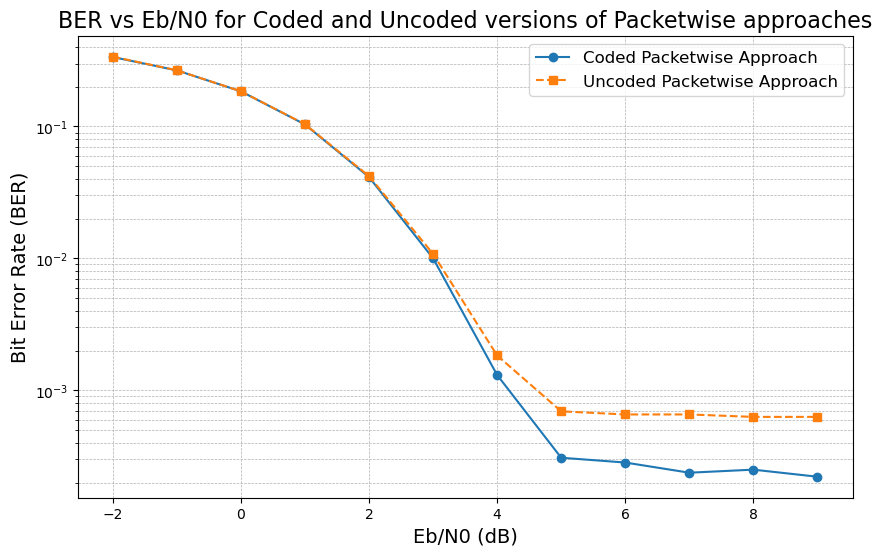

In [153]:
plt.figure(figsize=(10, 6))
snr_values_np = np.array(snr_values)
# Plot the BER for the autoregressive approach
plt.plot(snr_values_np/2, ber_coded_list, marker='o', linestyle='-', label='Coded Packetwise Approach')
# Plot the BER for the packetwise approach
plt.plot(snr_values_np/2, ber_uncoded_list, marker='s', linestyle='--', label='Uncoded Packetwise Approach')
# Set the y-axis to a logarithmic scale
plt.yscale('log')
plt.xlabel('Eb/N0 (dB)', fontsize=14)
plt.ylabel('Bit Error Rate (BER)', fontsize=14)
plt.title('BER vs Eb/N0 for Coded and Uncoded versions of Packetwise approaches', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

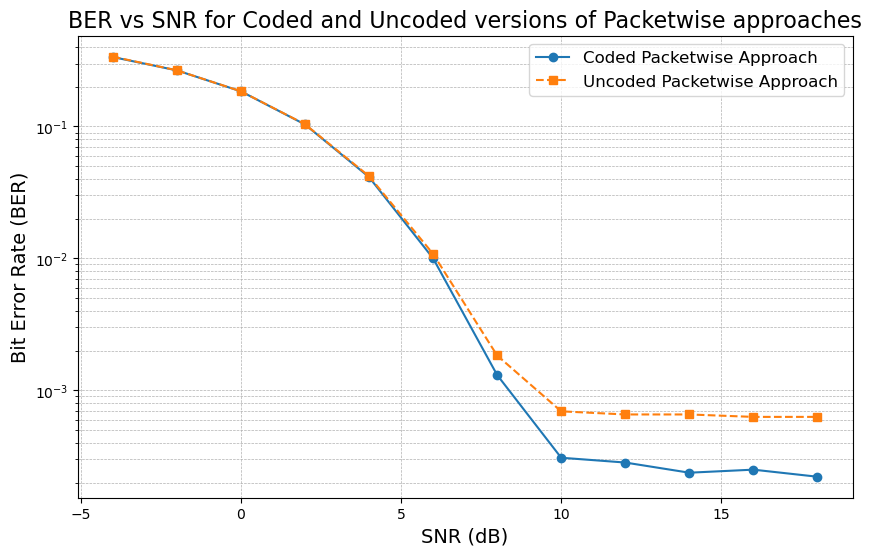

In [154]:
plt.figure(figsize=(10, 6))
#snr_values_np = np.array(snr_values)
# Plot the BER for the autoregressive approach
plt.plot(snr_values, ber_coded_list, marker='o', linestyle='-', label='Coded Packetwise Approach')
# Plot the BER for the packetwise approach
plt.plot(snr_values, ber_uncoded_list, marker='s', linestyle='--', label='Uncoded Packetwise Approach')
# Set the y-axis to a logarithmic scale
plt.yscale('log')
plt.xlabel('SNR (dB)', fontsize=14)
plt.ylabel('Bit Error Rate (BER)', fontsize=14)
plt.title('BER vs SNR for Coded and Uncoded versions of Packetwise approaches', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [ ]:
# # Case 2: Irregular LDPC 
# n2 = 18  # Block length (same for comparison)
# d_v2 = [2, 4, 6]  # Variable node degree (irregular distribution)
# d_c2 = [4, 8, 6]  # Check node degree (irregular distribution)

# # Manually construct H and G for irregular LDPC
# # pyldpc does not directly support irregular graphs, but here's a simple trick
# # Generate a custom irregular graph and extract H and G
# H2, G2 = make_ldpc(n2, np.mean(d_v2), np.mean(d_c2), systematic=True, sparse=True)  # Approximation

# #Generate message
# original_message = np.random.randint(2, size=k)  # Random 10-bit message
# print(f"Original Message: {original_message}")

# #Create the parity-check and generator matrices which depend on n, d_v and d_c
# H1, G1 = make_ldpc(n1, d_v1, d_c1, systematic=True, sparse=True)
# print(H1)

# #Encoding
# encoded_message1 = encode(G1, original_message, snr) 
# print(f"Encoded Message (Regular): {encoded_message1}")

# #Transmission of encoded signal through the channel
# received_message1 = transmit_data_awgn(encoded_message1, snr)

# #Decoding of the bits after converting all the received symbols into bits - the decode function handles the AWGN channel estimation as a hard decoder
# decoded_message1 = decode(H1, received_message1, snr)
# print(f"Decoded Message: {decoded_message1}")

# #Decoding of code bits into original data bits
# recovered_message1 = get_message(G1, decoded_message1)
# print(f"Recovered Message (Regular): {recovered_message1}")

# # Verify
# assert np.array_equal(original_message, recovered_message1), "Error in LDPC!"